# 🧪 Digital Gait Laboratory: From Raw Sensors to AI

**Course:** Wearable Computing & Gait Analysis  
**Dataset:** UCI HAPT (Activity Recognition + Postural Transitions)

### 🎯 Objective
In this laboratory, we will build a complete end-to-end pipeline to:
1.  **Ingest Raw Sensor Data:** Read continuous accelerometer and gyroscope streams.
2.  **Signal Processing:** Apply noise filtering and gravity separation.
3.  **Segmentation:** Slice the continuous signal into fixed-size "windows" (Strides/Movements).
4.  **Deep Learning:** Train a 1D-Convolutional Neural Network (CNN) in PyTorch.
5.  **Real-World Test:** Import data from your own smartphone (Phyphox) and classify it.

---

### 🛠️ 1. Environment Setup

In [16]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.signal import butter, lfilter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Configuration
FS = 50              # Sampling Frequency (Hz)
WINDOW_SIZE = 128    # 2.56 seconds per window
OVERLAP = 64         # 50% overlap
BATCH_SIZE = 64
EPOCHS = 30
LR = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 📥 2. Download and Prepare Dataset
We will download the UCI HAPT dataset. It contains `RawData` text files (accel/gyro) and a `labels.txt` that tells us which samples correspond to which activity.

In [2]:
# Download Dataset (If not already present)
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip"
zip_path = "HAPT_Data_Set.zip"
extract_folder = "HAPT_Dataset"

if not os.path.exists(extract_folder):
    print("Downloading dataset...")
    !wget -q $dataset_url -O $zip_path
    print("Extracting...")
    !unzip -q $zip_path -d $extract_folder
    print("Done!")
else:
    print("Dataset already exists.")

Dataset already exists.


### 🧹 3. Signal Processing Helper Functions
Raw sensor data contains **Gravity** (a constant force) and **Body Acceleration** (dynamic movement). For gait analysis, it is crucial to separate them.

We use a **Butterworth Low-Pass Filter**:
* **Low Frequency (< 0.3Hz):** Gravity component.
* **High Frequency (> 0.3Hz):** Body movement.

In [3]:
def butter_lowpass(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def separate_gravity(data, fs=50):
    # Low-pass filter to isolate gravity
    b, a = butter_lowpass(cutoff=0.3, fs=fs, order=3)
    gravity = lfilter(b, a, data, axis=0)
    
    # Subtract gravity to get body acceleration
    body_acc = data - gravity
    return body_acc, gravity

### 🏗️ 4. Data Parsing & Segmentation
This is the core engineering step. We must:
1.  Read `labels.txt` to find where activities start and end.
2.  Load the corresponding raw file (e.g., `acc_exp01_user01.txt`).
3.  Extract the segment.
4.  Apply sliding window to chop it into fixed-size inputs for the CNN.

In [4]:
def load_hapt_data(base_path):
    raw_path = os.path.join(base_path, "RawData")
    
    # Read Labels: [Experiment, User, Activity, Start, End]
    labels_df = pd.read_csv(os.path.join(raw_path, "labels.txt"), sep='\\s+', header=None)
    labels_df.columns = ["exp", "user", "act", "start", "end"]
    
    processed_windows = []
    processed_labels = []

    # Group by Experiment to avoid reloading files repeatedly
    for exp_id in labels_df['exp'].unique():
        # Find the user for this experiment
        user_id = labels_df[labels_df['exp'] == exp_id]['user'].iloc[0]
        
        # Format filenames (e.g., acc_exp01_user01.txt)
        acc_file = f"acc_exp{exp_id:02d}_user{user_id:02d}.txt"
        gyro_file = f"gyro_exp{exp_id:02d}_user{user_id:02d}.txt"
        
        # Load Raw Data
        acc_raw = pd.read_csv(os.path.join(raw_path, acc_file), sep='\\s+', header=None).values
        gyro_raw = pd.read_csv(os.path.join(raw_path, gyro_file), sep='\\s+', header=None).values
        
        # Preprocess: Separate Gravity
        body_acc, gravity = separate_gravity(acc_raw, FS)
        
        # We will use 9 channels: [BodyAccXYZ, GyroXYZ, TotalAccXYZ]
        # This matches standard deep learning architectures for HAR
        full_data = np.hstack([body_acc, gyro_raw, acc_raw])
        
        # Iterate through labeled segments in this experiment
        exp_labels = labels_df[labels_df['exp'] == exp_id]
        
        for _, row in exp_labels.iterrows():
            start, end, act_id = row['start'], row['end'], row['act']
            
            # Extract the activity segment
            segment = full_data[start:end]
            
            # Sliding Window Segmentation
            # We slide a window of WINDOW_SIZE over this segment
            for i in range(0, len(segment) - WINDOW_SIZE, OVERLAP):
                window = segment[i : i + WINDOW_SIZE]
                
                processed_windows.append(window)
                processed_labels.append(act_id - 1) # Adjust labels 1-12 to 0-11

    return np.array(processed_windows), np.array(processed_labels)

# Run the loading process
print("Processing Raw Data... This may take a minute.")
X_all, y_all = load_hapt_data("HAPT_Dataset")

# Convert to Channels-First format for PyTorch (N, Channels, Time)
X_all = np.transpose(X_all, (0, 2, 1))

print(f"Final Dataset Shape: {X_all.shape}")
print(f"Labels Shape: {y_all.shape}")

Processing Raw Data... This may take a minute.
Final Dataset Shape: (10890, 9, 128)
Labels Shape: (10890,)


### 🧠 5. Neural Network Architecture (1D-CNN)
We design a Convolutional Neural Network specialized for time-series.

* **Conv1d Layers:** Extract features (like peaks, curves) from the signal.
* **BatchNorm:** Stabilizes training.
* **MaxPooling:** Reduces dimensionality.
* **Global Average Pooling:** Summarizes the entire window into a feature vector.

In [5]:
class GaitCNN(nn.Module):
    def __init__(self, n_channels=9, n_classes=12):
        super(GaitCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv1d(n_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Block 2
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(kernel_size=2),
            
            # Block 3
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),         # Global Pooling
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### 🏋️ 6. Training Loop

In [6]:
# 1. PyTorch Dataset Wrapper
class TensorDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.LongTensor(y)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

# 2. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

# 3. Initialize Model
model = GaitCNN(n_channels=9, n_classes=12).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# 4. Train
train_losses, test_accs = [], []

print("Starting Training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validation Step
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = 100 * correct / total
    test_accs.append(acc)
    train_losses.append(running_loss/len(train_loader))
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {train_losses[-1]:.4f} | Test Acc: {acc:.2f}%")

print("Training Complete.")

# Save the model
torch.save(model.state_dict(), "gait_hapt_model.pth")

Starting Training...
Epoch [1/30] Loss: 0.4625 | Test Acc: 90.40%
Epoch [2/30] Loss: 0.1944 | Test Acc: 92.79%
Epoch [3/30] Loss: 0.1684 | Test Acc: 93.80%
Epoch [4/30] Loss: 0.1580 | Test Acc: 92.93%
Epoch [5/30] Loss: 0.1605 | Test Acc: 93.71%
Epoch [6/30] Loss: 0.1653 | Test Acc: 93.34%
Epoch [7/30] Loss: 0.1439 | Test Acc: 92.70%
Epoch [8/30] Loss: 0.1432 | Test Acc: 93.11%
Epoch [9/30] Loss: 0.1363 | Test Acc: 93.34%
Epoch [10/30] Loss: 0.1304 | Test Acc: 94.67%
Epoch [11/30] Loss: 0.1246 | Test Acc: 94.77%
Epoch [12/30] Loss: 0.1232 | Test Acc: 94.31%
Epoch [13/30] Loss: 0.1170 | Test Acc: 94.72%
Epoch [14/30] Loss: 0.1207 | Test Acc: 94.17%
Epoch [15/30] Loss: 0.1261 | Test Acc: 94.58%
Epoch [16/30] Loss: 0.1270 | Test Acc: 94.49%
Epoch [17/30] Loss: 0.1116 | Test Acc: 94.77%
Epoch [18/30] Loss: 0.1160 | Test Acc: 94.17%
Epoch [19/30] Loss: 0.1081 | Test Acc: 95.00%
Epoch [20/30] Loss: 0.1062 | Test Acc: 93.80%
Epoch [21/30] Loss: 0.1058 | Test Acc: 95.59%
Epoch [22/30] Loss: 0.

### 📲 7. Phyphox: Import Your Own Data
This section allows you to upload `Accelerometer.csv` and `Gyroscope.csv` from Phyphox and classify your own movements.

**Instructions:**
1.  Record data in Phyphox (Raw Sensors: Accel + Gyro).
2.  Export to CSV.
3.  Upload files to this notebook environment.
4.  Run the cells below.

In [13]:
# Mapping for HAPT Labels
HAPT_LABELS = {
    0: "WALKING",
    1: "WALK_UP",
    2: "WALK_DOWN",
    3: "SITTING",
    4: "STANDING",
    5: "LAYING",
    6: "STAND_TO_SIT",
    7: "SIT_TO_STAND",
    8: "SIT_TO_LIE",
    9: "LIE_TO_SIT",
    10: "STAND_TO_LIE",
    11: "LIE_TO_STAND"
}

def preprocess_phyphox(acc_path, gyro_path):
    print(f"Loading {acc_path} and {gyro_path}...")
    try:
        df_acc = pd.read_csv(acc_path)
        df_gyro = pd.read_csv(gyro_path)
    except FileNotFoundError:
        print("⚠️ Error: Files not found. Please upload Accelerometer.csv and Gyroscope.csv")
        return None
    
    # Standardize column names using simple keyword matching
    def clean_cols(df):
        col_map = {}
        for c in df.columns:
            c_lower = c.lower()
            if 'time' in c_lower: col_map[c] = 'time'
            elif 'x' in c_lower: col_map[c] = 'x'
            elif 'y' in c_lower: col_map[c] = 'y'
            elif 'z' in c_lower: col_map[c] = 'z'
        return df.rename(columns=col_map)[['time', 'x', 'y', 'z']]

    df_acc = clean_cols(df_acc)
    df_gyro = clean_cols(df_gyro)

    df_acc[['x', 'y', 'z']] = df_acc[['x', 'y', 'z']] / 9.80665

    # Resample to 50Hz (Same as HAPT)
    t_start = max(df_acc['time'].min(), df_gyro['time'].min())
    t_end = min(df_acc['time'].max(), df_gyro['time'].max())
    new_time = np.arange(t_start, t_end, 1/50.0)

    def resample(df, t_target):
        df = df.set_index('time')
        # Reindex + Interpolate
        return df.reindex(df.index.union(t_target)).interpolate(method='linear').reindex(t_target).values

    acc_data = resample(df_acc, new_time)
    gyro_data = resample(df_gyro, new_time)

    # Feature Engineering (Gravity Separation)
    body_acc, gravity = separate_gravity(acc_data, fs=50)
    
    # Stack channels: [BodyAcc, Gyro, TotalAcc]
    full_signal = np.hstack([body_acc, gyro_data, acc_data])
    
    # Windowing
    windows = []
    for i in range(0, len(full_signal) - WINDOW_SIZE, OVERLAP):
        windows.append(full_signal[i : i + WINDOW_SIZE])
        
    if len(windows) == 0:
        print("Recording too short.")
        return None
        
    # To Tensor (N, 9, 128)
    X_phy = np.array(windows).transpose(0, 2, 1)
    return torch.FloatTensor(X_phy)

# INFERENCE FUNCTION
def classify_my_movement(acc_file, gyro_file):
    data = preprocess_phyphox(acc_file, gyro_file)
    if data is None: return

    model.eval()
    with torch.no_grad():
        outputs = model(data.to(device))
        _, preds = torch.max(outputs, 1)

    # Display Results
    print("\n--- 📊 Classification Results ---")
    unique, counts = np.unique(preds.cpu().numpy(), return_counts=True)
    total = sum(counts)
    
    for cls_idx, count in zip(unique, counts):
        percentage = (count / total) * 100
        print(f"{HAPT_LABELS[cls_idx]}: {percentage:.1f}%")

# Uncomment this to run if you have uploaded files:
classify_my_movement("Accelerometer.csv", "Gyroscope.csv")

Loading Accelerometer.csv and Gyroscope.csv...

--- 📊 Classification Results ---
WALKING: 52.8%
WALK_UP: 2.8%
WALK_DOWN: 2.8%
SIT_TO_LIE: 5.6%
STAND_TO_LIE: 33.3%
LIE_TO_STAND: 2.8%


Loading Accelerometer.csv and Gyroscope.csv...
Generating plot...


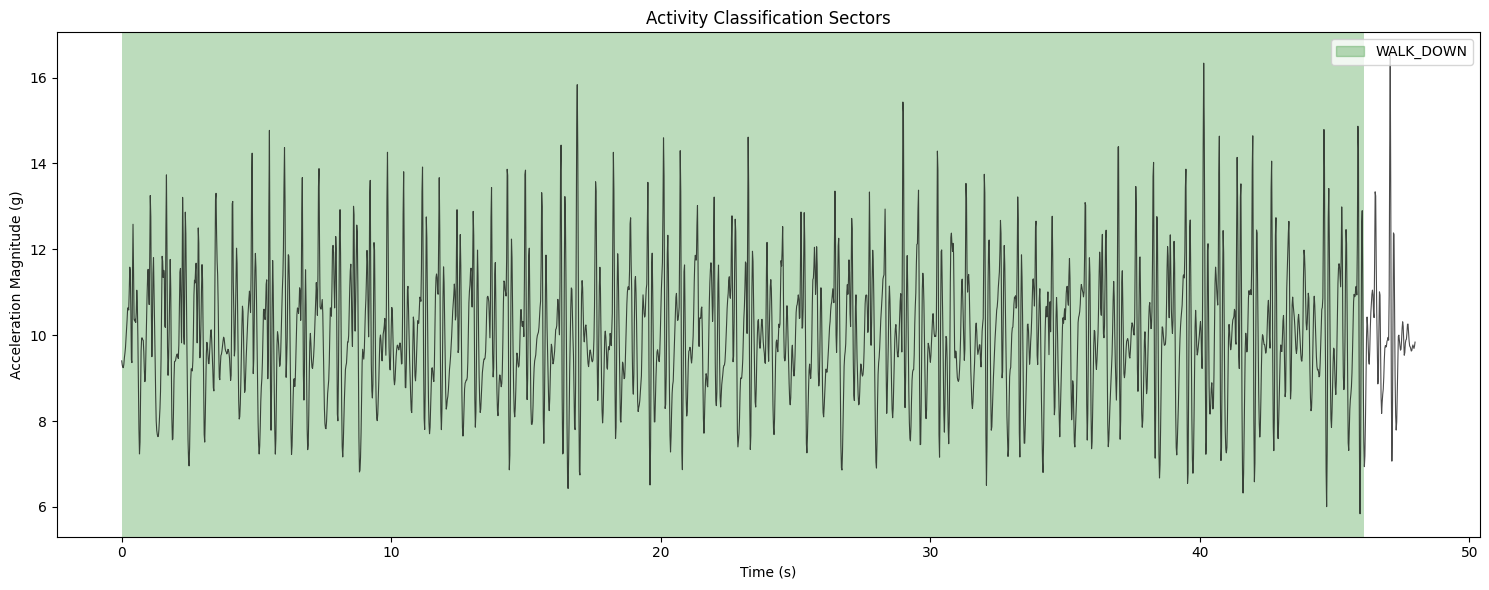

In [19]:
HAPT_LABELS = {
    0: "WALKING", 1: "WALK_UP", 2: "WALK_DOWN",
    3: "SITTING", 4: "STANDING", 5: "LAYING",
    6: "STAND_TO_SIT", 7: "SIT_TO_STAND", 8: "SIT_TO_LIE",
    9: "LIE_TO_SIT", 10: "STAND_TO_LIE", 11: "LIE_TO_STAND"
}

# distinct colors for the 12 classes
LABEL_COLORS = {
    0: 'green', 1: 'lime', 2: 'forestgreen',    # Walking variations (Greens)
    3: 'blue', 4: 'navy', 5: 'cyan',             # Static postures (Blues)
    6: 'orange', 7: 'darkorange',                # Transitions (Oranges/Reds)
    8: 'red', 9: 'darkred',
    10: 'purple', 11: 'violet'
}

def preprocess_phyphox(acc_path, gyro_path):
    print(f"Loading {acc_path} and {gyro_path}...")
    try:
        df_acc = pd.read_csv(acc_path)
        df_gyro = pd.read_csv(gyro_path)
    except FileNotFoundError:
        print("⚠️ Error: Files not found.")
        return None, None, None
    
    # 1. Clean Columns
    def clean_cols(df):
        col_map = {}
        for c in df.columns:
            c_lower = c.lower()
            if 'time' in c_lower: col_map[c] = 'time'
            elif 'x' in c_lower: col_map[c] = 'x'
            elif 'y' in c_lower: col_map[c] = 'y'
            elif 'z' in c_lower: col_map[c] = 'z'
        return df.rename(columns=col_map)[['time', 'x', 'y', 'z']]

    df_acc = clean_cols(df_acc)
    df_gyro = clean_cols(df_gyro)

    # 2. Scale Accelerometer (The fix you requested)
    #df_acc[['x', 'y', 'z']] = df_acc[['x', 'y', 'z']] / 10.0

    # 3. Resample to 50Hz
    t_start = max(df_acc['time'].min(), df_gyro['time'].min())
    t_end = min(df_acc['time'].max(), df_gyro['time'].max())
    new_time = np.arange(t_start, t_end, 1/FS)

    def resample(df, t_target):
        df = df.set_index('time')
        df = df[~df.index.duplicated(keep='first')] # Drop duplicate times if any
        return df.reindex(df.index.union(t_target)).interpolate(method='linear').reindex(t_target).values

    acc_data = resample(df_acc, new_time)
    gyro_data = resample(df_gyro, new_time)

    # 4. Feature Engineering (Gravity Separation)
    # (Assuming separate_gravity is defined elsewhere, otherwise using raw)
    try:
        body_acc, gravity = separate_gravity(acc_data, fs=FS)
    except NameError:
        body_acc = acc_data 

    full_signal = np.hstack([body_acc, gyro_data, acc_data])
    
    # 5. Windowing
    windows = []
    for i in range(0, len(full_signal) - WINDOW_SIZE, OVERLAP):
        windows.append(full_signal[i : i + WINDOW_SIZE])
        
    if len(windows) == 0:
        return None, None, None
        
    X_phy = np.array(windows).transpose(0, 2, 1)
    
    # RETURN: Tensor AND the raw data/time for plotting
    return torch.FloatTensor(X_phy), acc_data, new_time

def classify_and_plot(acc_file, gyro_file):
    # 1. Preprocess and get data back
    tensor_data, raw_acc, time_axis = preprocess_phyphox(acc_file, gyro_file)
    
    if tensor_data is None:
        return

    # 2. Inference
    model.eval()
    with torch.no_grad():
        outputs = model(tensor_data.to(device))
        _, preds = torch.max(outputs, 1)
    
    preds = preds.cpu().numpy()

    # 3. Visualization
    print("Generating plot...")
    plt.figure(figsize=(15, 6))
    
    # Calculate Total Acceleration (Magnitude) for a cleaner plot
    acc_mag = np.sqrt(np.sum(raw_acc**2, axis=1))
    
    # Plot the signal line
    plt.plot(time_axis, acc_mag, color='black', linewidth=0.8, alpha=0.7, label='Total Acc')

    # Overlay colored sectors
    # We iterate through predictions and highlight the corresponding time window
    legend_patches = {}
    
    for i, pred_class in enumerate(preds):
        # Calculate start/end index in the original time array
        # Note: We map the prediction to the 'step' of the window to avoid messy overlaps in drawing
        start_idx = i * OVERLAP
        end_idx = start_idx + OVERLAP
        
        if end_idx >= len(time_axis): break
        
        t_start = time_axis[start_idx]
        t_end = time_axis[end_idx]
        
        color = LABEL_COLORS.get(pred_class, 'gray')
        label_name = HAPT_LABELS.get(pred_class, 'Unknown')
        
        # Add colored span
        plt.axvspan(t_start, t_end, color=color, alpha=0.3, lw=0)
        
        # Store for legend
        if label_name not in legend_patches:
            legend_patches[label_name] = mpatches.Patch(color=color, label=label_name, alpha=0.3)

    plt.title('Activity Classification Sectors')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration Magnitude (g)')
    
    # Create a custom legend for only the detected activities
    plt.legend(handles=list(legend_patches.values()), loc='upper right')
    plt.tight_layout()
    plt.show()

# Run
classify_and_plot("Accelerometer.csv", "Gyroscope.csv")